In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from model import C2F_TCN
from dataset import AugmentDataset, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='5'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=50,
    learning_rate=1e-4,
    weight_decay=3e-3,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=10,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=2,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-full-length/",
    project_name="breakfast-split-2",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 50, 'learning_rate': 0.0001, 'weight_decay': 0.003, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 10, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 2, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-full-length/', 'project_name': 'breakfast-split-2', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split2.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split2.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_sp

In [7]:
traindataset = AugmentDataset(config, fold='train', fold_file_name=config.train_split_file, augment=False)
testdataset = AugmentDataset(config, fold='test', fold_file_name=config.test_split_file, augment=False)

Number of videos logged in train fold is 1261
Number of videos not found in train fold is 0
Number of videos logged in test fold is 451
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=False, num_workers=4, collate_fn=collate_fn_override,
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=False, num_workers=4, collate_fn=collate_fn_override,
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [10]:
loaded_vidid_selected_frames = pickle.load(open("dump_dir/breakfast_split2_selected_frames_dict.pkl", "rb"))
# loaded_vidid_selected_frames
video_id_boundary_frames = pickle.load(open("dump_dir/breakfast_split2_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames

In [11]:
loaded_mean_var_actions = pickle.load(open("dump_dir/mean_var_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class, min_len):
    mean_class, std_class = loaded_mean_var_actions[cur_class]   
    prob = (cur_len * np.log(mean_class + 1e-5))
    prob = prob - mean_class
    prob = prob - np.sum(np.log(np.arange(1, cur_len, 1)))
    return prob

get_possion_prob(20, 20, 10)

0.48488744950308416

In [12]:
prob_video_each_segment_dict = {}

In [13]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):
        
        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[cur_ele]
        label_next_ele = labels[next_ele]
        prob_list = []
        for ele in range(cur_ele, next_ele, 1):
            start_sum = cumsum_feat[cur_ele - 1, :] if cur_ele > 0 else 0
            sum_window_class_1 = (cumsum_feat[ele, :] - start_sum)[label_cur_ele]
            sum_window_class_2 = (cumsum_feat[next_ele - 1, :] - cumsum_feat[ele, :])[label_next_ele]
            
            len_cur_class = ele - cur_boundary
            len_prob = get_possion_prob(len_cur_class, label_cur_ele.item(), cur_ele)
            prob_list.append((sum_window_class_1 + sum_window_class_2) + len_prob.item())
            
        prob_list = torch.softmax(torch.stack(prob_list), dim=0)
        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob_list.detach().cpu().numpy()).item())
        prob_each_segment.append(prob_list)
    
    return prob_each_segment

In [14]:
# selected_frames = torch.tensor([2, 10, 17, 21])
# cur_vid_feat = torch.randn((27, 48))
# labels = torch.tensor([47, 47, 47, 47, 47, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10])
# # print(len(labels))
# probs_all_segs = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
# print(probs_all_segs)

In [15]:
def calculate_element_probb(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid]
        prob_video = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [16]:
def get_estimated_loss(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid]
        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames[0]
        if start_ele_idx > 0:
            start_ele_label_idx = labels[selected_frames[0]]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob)
        
        for i, cur_ele in enumerate(selected_frames[:-1]):
            next_ele = selected_frames[i + 1]
            label_cur_ele = labels[cur_ele]
            label_next_ele = labels[next_ele]

            count = 0
            for ele in range(cur_ele, next_ele, 1):
                start_sum = cumsum_feat[cur_ele - 1, :] if cur_ele > 0 else 0
                sum_window_class_1 = (cumsum_feat[ele, :] - start_sum)[label_cur_ele]
                sum_window_class_2 = (cumsum_feat[next_ele - 1, :] - cumsum_feat[ele, :])[label_next_ele]
                current_vid_prob_arr.append((sum_window_class_1 + sum_window_class_2)  * (prob_each_video[i][count].item()))
                count = count + 1
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = labels[selected_frames[-1]]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames[-1] - 1, :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob)
            
        loss_arr.append(torch.stack(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr
#     return loss_arr

In [17]:
def get_estimated_boundaries():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames, video_id_boundary_frames
    estimated_boundary_dict = {}
    for ele in video_id_boundary_frames.keys():
        
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        selected_ele_list = loaded_vidid_selected_frames[ele]
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_ele_list[i], selected_ele_list[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_ele_list[i]) or (estimated_boundary > selected_ele_list[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [18]:
def get_boundary_err():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for ele in video_id_boundary_frames.keys():
        
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(video_id_boundary_frames[ele][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = video_id_boundary_frames[ele][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")


In [19]:
def get_validation_acc(model):
    model.eval()
    print("Calculating Validation Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item[0] = item[0].to(device)
            item[1] = item[1].to(device)
            item[2] = item[2].to(device)
            y, _, features = model(item[0].permute(0,2,1))
            prob = torch.softmax(y, dim=1).permute(0,2,1)

            src_mask = torch.arange(item[2].shape[1], device=item[2].device)[None, :] < item[1][:, None]
            pred = torch.argmax(prob, dim=2)
            correct += float(torch.sum((pred == item[2]) * src_mask).item())
            total += float(torch.sum(src_mask).item())
    val_acc = correct * 100.0 / total
    print(f"Validation Accuracy calculated with model probabilities {val_acc: .3f}")
    return val_acc

In [20]:
set_seed()
model = C2F_TCN(n_channels=config.feature_size, n_classes=config.num_class).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=3e-3)

# Requires loaded_vidid_selected_frames, boundaries_dict
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [21]:
val_acc_arr = []
for epoch in range(2000):
    if epoch % 5 == 0:
        model.eval()
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0
        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item[0] = item[0].to(device)
                item[1] = item[1].to(device)
                item[2] = item[2].to(device)
                y, _, features = model(item[0].permute(0,2,1))
                prob = torch.softmax(y, dim=1)
                prob = prob.permute(0,2,1)
                calculate_element_probb(prob, item[1], item[5], item[2])
                
                src_mask = torch.arange(item[2].shape[1], device=item[2].device)[None, :] < item[1][:, None]
                pred = torch.argmax(prob, dim=2)
                correct += float(torch.sum((pred == item[2]) * src_mask).item())
                total += float(torch.sum(src_mask).item())
        print(f"Epoch {epoch} Train Accuracy calculated with probabilities {correct * 100.0 / total: .3f}")
        get_boundary_err()
        
        val_acc = get_validation_acc(model)
        val_acc_arr.append(val_acc)
        val_acc_arr.sort()
        print(f"Epoch {epoch} " + "Best 3 val accuracy till now = ", val_acc_arr[-3:])

    model.train()
    print("Starting Maximization")
    for i, item in enumerate(trainloader):
        item[0] = item[0].to(device)
        item[1] = item[1].to(device)
        
        optimizer.zero_grad()
        y, _, features = model(item[0].permute(0,2,1))
        prob = torch.softmax(y, dim=1)
        prob = prob.permute(0,2,1)
        loss, _ = get_estimated_loss(prob, item[1], item[5], item[2].to(device))
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f"Epoch {epoch} iteration {i} Current loss {loss.item()}")

Calculating Expectation


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch 0 Train Accuracy calculated with probabilities  4.757
Train Boundary avergage error = 39.697
Train From boundary avergage accuracy = 24.351
Calculating Validation Accuracy


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Validation Accuracy calculated with model probabilities  4.401
Epoch 0 Best 3 val accuracy till now =  [4.400578751550228]
Starting Maximization
Epoch 0 iteration 0 Current loss 4.669274806976318
Epoch 0 iteration 10 Current loss 3.440591812133789
Epoch 0 iteration 20 Current loss 3.051687240600586
Starting Maximization
Epoch 1 iteration 0 Current loss 2.6835663318634033
Epoch 1 iteration 10 Current loss 2.2878682613372803
Epoch 1 iteration 20 Current loss 2.1977484226226807
Starting Maximization
Epoch 2 iteration 0 Current loss 2.0904455184936523
Epoch 2 iteration 10 Current loss 1.8432239294052124
Epoch 2 iteration 20 Current loss 1.9856774806976318
Starting Maximization
Epoch 3 iteration 0 Current loss 1.7530766725540161
Epoch 3 iteration 10 Current loss 1.7674217224121094
Epoch 3 iteration 20 Current loss 1.5416849851608276
Starting Maximization
Epoch 4 iteration 0 Current loss 1.5700007677078247
Epoch 4 iteration 10 Current loss 1.5440447330474854
Epoch 4 iteration 20 Current loss

Epoch 32 iteration 20 Current loss 0.44102808833122253
Starting Maximization
Epoch 33 iteration 0 Current loss 0.27078941464424133
Epoch 33 iteration 10 Current loss 0.23444806039333344
Epoch 33 iteration 20 Current loss 0.24362123012542725
Starting Maximization
Epoch 34 iteration 0 Current loss 0.18530450761318207
Epoch 34 iteration 10 Current loss 0.16641293466091156
Epoch 34 iteration 20 Current loss 0.1761428713798523
Calculating Expectation
Epoch 35 Train Accuracy calculated with probabilities  73.716
Train Boundary avergage error = 41.315
Train From boundary avergage accuracy = 26.626
Calculating Validation Accuracy
Validation Accuracy calculated with model probabilities  57.898
Epoch 35 Best 3 val accuracy till now =  [57.897891690781314, 57.971269119470854, 58.220338983050844]
Starting Maximization
Epoch 35 iteration 0 Current loss 0.1559787392616272
Epoch 35 iteration 10 Current loss 0.2179332673549652
Epoch 35 iteration 20 Current loss 0.1828330159187317
Starting Maximization

Calculating Expectation
Epoch 65 Train Accuracy calculated with probabilities  74.398
Train Boundary avergage error = 41.455
Train From boundary avergage accuracy = 23.720
Calculating Validation Accuracy
Validation Accuracy calculated with model probabilities  56.830
Epoch 65 Best 3 val accuracy till now =  [59.04195948739149, 59.13393964448119, 59.60004133939645]
Starting Maximization
Epoch 65 iteration 0 Current loss 0.11294989287853241
Epoch 65 iteration 10 Current loss 0.1330275982618332
Epoch 65 iteration 20 Current loss 0.1186104267835617
Starting Maximization
Epoch 66 iteration 0 Current loss 0.1623528003692627
Epoch 66 iteration 10 Current loss 0.22026269137859344
Epoch 66 iteration 20 Current loss 0.23858599364757538
Starting Maximization
Epoch 67 iteration 0 Current loss 0.1924668848514557
Epoch 67 iteration 10 Current loss 0.1940590739250183
Epoch 67 iteration 20 Current loss 0.15175281465053558
Starting Maximization
Epoch 68 iteration 0 Current loss 0.1481001228094101
Epoch

Epoch 97 iteration 10 Current loss 0.0931205078959465
Epoch 97 iteration 20 Current loss 0.0662558302283287
Starting Maximization
Epoch 98 iteration 0 Current loss 0.17259442806243896
Epoch 98 iteration 10 Current loss 0.27274733781814575
Epoch 98 iteration 20 Current loss 0.46937015652656555
Starting Maximization
Epoch 99 iteration 0 Current loss 0.2515192925930023
Epoch 99 iteration 10 Current loss 0.25128284096717834
Epoch 99 iteration 20 Current loss 0.2451382726430893
Calculating Expectation
Epoch 100 Train Accuracy calculated with probabilities  72.401
Train Boundary avergage error = 41.633
Train From boundary avergage accuracy = 20.336
Calculating Validation Accuracy
Validation Accuracy calculated with model probabilities  54.695
Epoch 100 Best 3 val accuracy till now =  [59.942124844977265, 60.585985944605206, 60.96940884663084]
Starting Maximization
Epoch 100 iteration 0 Current loss 0.14687776565551758
Epoch 100 iteration 10 Current loss 0.19418905675411224
Epoch 100 iteratio

Epoch 129 iteration 10 Current loss 0.05790217965841293
Epoch 129 iteration 20 Current loss 0.06266678869724274
Calculating Expectation
Epoch 130 Train Accuracy calculated with probabilities  74.286
Train Boundary avergage error = 41.472
Train From boundary avergage accuracy = 20.193
Calculating Validation Accuracy
Validation Accuracy calculated with model probabilities  59.893
Epoch 130 Best 3 val accuracy till now =  [60.585985944605206, 60.64902852418355, 60.96940884663084]
Starting Maximization
Epoch 130 iteration 0 Current loss 0.059183571487665176
Epoch 130 iteration 10 Current loss 0.06364989280700684
Epoch 130 iteration 20 Current loss 0.07636531442403793
Starting Maximization
Epoch 131 iteration 0 Current loss 0.06966815143823624
Epoch 131 iteration 10 Current loss 0.06608980149030685
Epoch 131 iteration 20 Current loss 0.08148360252380371
Starting Maximization
Epoch 132 iteration 0 Current loss 0.07436225563287735
Epoch 132 iteration 10 Current loss 0.06375494599342346
Epoch 

Epoch 160 iteration 0 Current loss 0.0633947104215622
Epoch 160 iteration 10 Current loss 0.08608633279800415
Epoch 160 iteration 20 Current loss 0.08408123254776001
Starting Maximization
Epoch 161 iteration 0 Current loss 0.08079294860363007
Epoch 161 iteration 10 Current loss 0.08036668598651886
Epoch 161 iteration 20 Current loss 0.07556246966123581
Starting Maximization
Epoch 162 iteration 0 Current loss 0.06911704689264297
Epoch 162 iteration 10 Current loss 0.07939378917217255
Epoch 162 iteration 20 Current loss 0.07618632912635803
Starting Maximization
Epoch 163 iteration 0 Current loss 0.07314509153366089
Epoch 163 iteration 10 Current loss 0.06524534523487091
Epoch 163 iteration 20 Current loss 0.07040403038263321
Starting Maximization
Epoch 164 iteration 0 Current loss 0.06336274743080139
Epoch 164 iteration 10 Current loss 0.07320799678564072
Epoch 164 iteration 20 Current loss 0.07318583130836487
Calculating Expectation
Epoch 165 Train Accuracy calculated with probabilities

Epoch 192 iteration 0 Current loss 0.06475832313299179
Epoch 192 iteration 10 Current loss 0.057569991797208786
Epoch 192 iteration 20 Current loss 0.058419015258550644
Starting Maximization
Epoch 193 iteration 0 Current loss 0.04862362891435623
Epoch 193 iteration 10 Current loss 0.06267020106315613
Epoch 193 iteration 20 Current loss 0.07060834765434265
Starting Maximization
Epoch 194 iteration 0 Current loss 0.0607239305973053
Epoch 194 iteration 10 Current loss 0.06799477338790894
Epoch 194 iteration 20 Current loss 0.06822129338979721
Calculating Expectation
Epoch 195 Train Accuracy calculated with probabilities  74.883
Train Boundary avergage error = 41.111
Train From boundary avergage accuracy = 18.552
Calculating Validation Accuracy
Validation Accuracy calculated with model probabilities  58.769
Epoch 195 Best 3 val accuracy till now =  [60.585985944605206, 60.64902852418355, 60.96940884663084]
Starting Maximization
Epoch 195 iteration 0 Current loss 0.06581664830446243
Epoch 1

KeyboardInterrupt: 

In [10]:
def get_selected_labels(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            select_item = np.random.randint(start, i, 1)[0]
            unique_ids.append(select_item)
            start = i
        prev_ele = ele
    
    select_item = np.random.randint(start, len(labels_arr), 1)[0]
    unique_ids.append(select_item)
    return unique_ids
# get_selected_labels(ab)

In [11]:
def get_boundary(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            unique_ids.append(i - 1)
            start = i
        prev_ele = ele
    
    unique_ids.append(len(labels_arr) - 1)
    return unique_ids
# get_boundary(np.array([2, 2, 2, 2, 3, 3, 4, 4, 4, 1, 1, 1, 1]))

In [12]:
loaded_vidid_selected_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        video_id = video_ids[i]
        labels = labels_all[i][:count]
        selected_ids = get_selected_labels(labels)

        loaded_vidid_selected_frames[video_id] = selected_ids

In [13]:
video_id_boundary_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        
        labels = labels_all[i][:count]
        selected_ids = get_boundary(labels)
        video_id = video_ids[i]
        video_id_boundary_frames[video_id] = selected_ids

In [14]:
for ele in video_id_boundary_frames.keys():
    if len(video_id_boundary_frames[ele]) != len(loaded_vidid_selected_frames[ele]):
        print(ele)

In [15]:
"""
loaded_vidid_selected_frames = pickle.load(open("dump_dir/breakfast_split2_selected_frames_dict.pkl", "rb"))
# loaded_vidid_selected_frames
video_id_boundary_frames = pickle.load(open("dump_dir/breakfast_split2_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames
"""
import pickle
pickle.dump(video_id_boundary_frames, open("dump_dir/breakfast_split2_selected_frames_dict.pkl", "wb"))
pickle.dump(loaded_vidid_selected_frames, open("dump_dir/breakfast_split2_boundary_frames_dict.pkl", "wb"))

In [55]:
def get_ensemble_out(outp):
    
    weights = [1, 1, 1, 1, 0, 0]
    ensemble_prob = F.softmax(outp[0], dim=1) * weights[0] / sum(weights)

    for i, outp_ele in enumerate(outp[1]):
        upped_logit = F.upsample(outp_ele, size=outp[0].shape[-1], mode='linear', align_corners=True)
        ensemble_prob = ensemble_prob + F.softmax(upped_logit, dim=1) * weights[i + 1] / sum(weights)
    
    return ensemble_prob

In [56]:
model.load_state_dict(torch.load('/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/results/c2f-tcn-model/split2_c2ftcn_model.wt'))

<All keys matched successfully>

In [21]:
model.eval()
loss_arr = []
correct = 0.0
total = 0.0
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item[0] = item[0].to(device)
        item[1] = item[1].to(device)
        y, y_list, _ = model(item[0].permute(0,2,1))
        prob = torch.softmax(y, dim=1).permute(0,2,1)
#         prob = get_ensemble_out([y, y_list]).permute(0,2,1)
        calculate_element_probb(prob, item[1], item[5], item[2].to(device))
        loss, _ = get_estimated_loss(prob, item[1], item[5], item[2].to(device))
        loss_arr.append(loss)
        
        estimated_labels = torch.argmax(prob, dim=2)
        correct += torch.sum(estimated_labels == )
#         probs = get_ensemble_out([y, y_list])
#         features = torch.log(probs + 1e-4).permute(0,2,1)
#         get_estimated_boundary(features, item[1], item[5])
get_boundary_err()
print("Average loss", torch.mean(torch.tensor(loss_arr)))

Boundary avergage error = 25.242
From boundary avergage accuracy = 69.543
tensor(0.4019)


In [22]:
for i in range(prob.shape[0]):
    loss_i, _ = get_estimated_loss(prob[i].unsqueeze(0), item[1][i].unsqueeze(0), [item[5][i]], item[2][i].unsqueeze(0))
    print(loss_i)
#     print(torch.mean(torch.cat(loss_i)))

tensor(0.4542, device='cuda:0')
tensor(0.1349, device='cuda:0')
tensor(1.5728, device='cuda:0')
tensor(0.6470, device='cuda:0')
tensor(0.2702, device='cuda:0')
tensor(0.5915, device='cuda:0')
tensor(2.8901, device='cuda:0')


In [65]:
loss_i

tensor(0.7432, device='cuda:0')

In [28]:
with torch.no_grad():
    idx = 6

    cur_vid_feat = prob[idx]
    cur_vidid = item[5][idx]
    labels = item[2][idx]
    selected_frames = torch.tensor(loaded_vidid_selected_frames[cur_vidid], dtype=torch.long, 
                                   device=cur_vid_feat.device)
    prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)

In [29]:
loss_i, _ = get_estimated_loss(prob[idx].unsqueeze(0), item[1][idx].unsqueeze(0), [item[5][idx]], item[2][idx].unsqueeze(0))

In [30]:
loss_i

tensor(2.8901, device='cuda:0')

(0, 1.2)

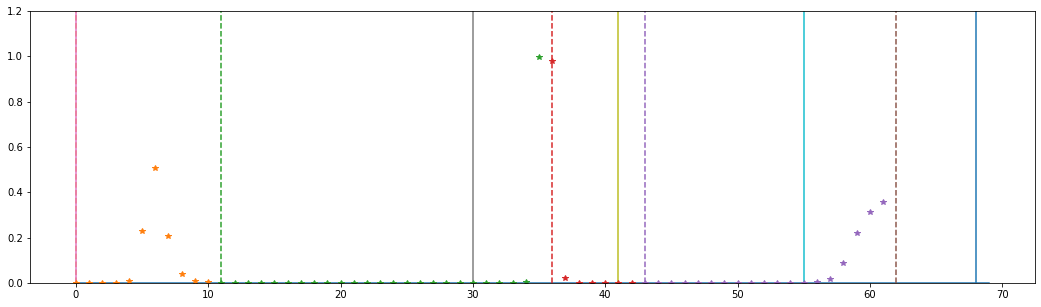

In [31]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1.2

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in loaded_vidid_selected_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
#     all_prob.append(segment/torch.sum(segment))
    prob_i = segment / torch.sum(segment)
    prob_i = prob_i.cpu().numpy()
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid][i], loaded_vidid_selected_frames[cur_vidid][i+1])
    plt.plot(xs, prob_i, '*')

plt.ylim([0, ymax])
# all_prob = torch.cat(all_prob).cpu().numpy()
# xs = np.arange(loaded_vidid_selected_frames[cur_vidid][0] + 1, loaded_vidid_selected_frames[cur_vidid][-1])
# plt.plot(xs, all_prob, '-')

In [80]:
cur_vid_feat = torch.softmax(y, dim=1).permute(0,2,1)[idx]
cur_vid_count = item[1][idx]
labels = item[2][idx]

selected_frames = loaded_vidid_selected_frames[cur_vidid]
prob_each_video = prob_video_each_segment_dict[cur_vidid]

log_probs = torch.log(cur_vid_feat + 1e-8)
cumsum_feat = torch.cumsum(log_probs, dim=0)

full_arr = []
for i, cur_ele in enumerate(selected_frames[:-1]):
    next_ele = selected_frames[i + 1]
    label_cur_ele = labels[cur_ele]
    label_next_ele = labels[next_ele]
    prob_list = [] 

    count = 0
    for ele in range(cur_ele, next_ele, 1):
        start_sum = cumsum_feat[cur_ele - 1, :] if cur_ele > 0 else 0
        sum_window_class_1 = (cumsum_feat[ele, :] - start_sum)[label_cur_ele]
        sum_window_class_2 = (cumsum_feat[next_ele - 1, :] - cumsum_feat[ele, :])[label_next_ele]
        prob_list.append((sum_window_class_1 + sum_window_class_2)  * (prob_each_video[i][count].item()))
        count = count + 1
    full_arr.append(torch.stack(prob_list))

In [81]:
-torch.mean(torch.cat(full_arr))

tensor(0.3756, device='cuda:0')

In [83]:
label_cur_ele

tensor(14)

In [84]:
label_next_ele

tensor(47)

In [85]:
selected_frames

[0, 10, 18, 60, 102, 183, 198, 242]

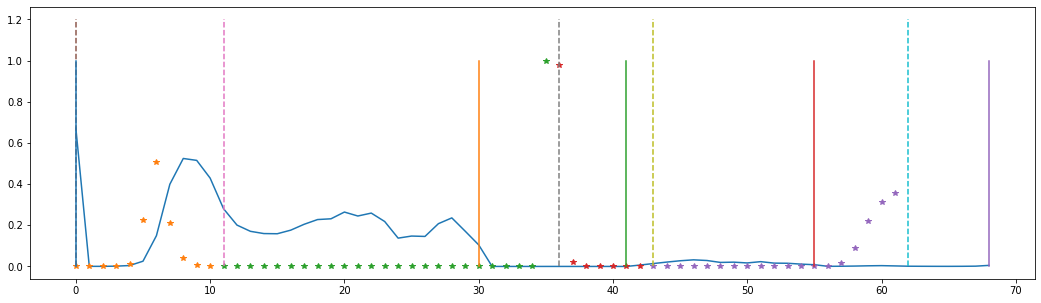

In [32]:
plt_arr = []


for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

all_prob = []
for i, segment in enumerate(prob_each_segment):
#     all_prob.append(segment/torch.sum(segment))
    prob_i = segment / torch.sum(segment)
    prob_i = prob_i.cpu().numpy()
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid][i], loaded_vidid_selected_frames[cur_vidid][i+1])
    plt.plot(xs, prob_i, '*')

for pivot in loaded_vidid_selected_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 1])